# Project 2: 2-Node Network

**Gillian McGovern, Dhanya Nair, Dirk Hartog**

Instructions:

1. Identify a large 2-node network dataset—you can start with a dataset in a repository.  Your data should meet the criteria that it consists of ties between and not within two (or more) distinct groups.
2. Reduce the size of the network using a method such as the island method described in chapter 4 of social network analysis.
3. What can you infer about each of the distinct groups?

Research Question:

How do people watch movies and how can we recommend new movies to users?

Motivation:

This research question allows us to investigate user behavior relating to watching movies, and trends within movies, such as the most popular movies. Additionally, we can find similar movies and users to recommend new movies.

Project Goals:

Identify the most popular movies

Recommend movies to users

## Data Source

This MovieLens data contains 100K amount of movie ratings from users. The two distinct node groups are users and movies.

The dataset is a CSV file containing:

*   userId: The user ID
*   movieId: The movie ID
*   rating: The user's rating for the movie
*   timestamp: Timestamp

Source: https://grouplens.org/datasets/movielens/


## Load Data

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.algorithms import bipartite
from collections import defaultdict

In [ ]:
# download data

!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2025-06-29 22:50:44--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.42MB/s    in 0.4s    

2025-06-29 22:50:45 (2.42 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
movies_df = pd.read_csv('ml-latest-small/ratings.csv', sep=",")

# Read in movie meta data (genre/title)
movies_data = pd.read_csv('ml-latest-small/movies.csv', sep=",")

# Create data frame
movies_df.columns = ['userId', 'movieId', 'rating', 'timestamp']
movies_df = movies_df[["userId", "movieId", "rating"]]

movies_df = movies_df.merge(movies_data, on = "movieId")

# Split the genres columns and only the first listed genre
movies_df["genres"] = movies_df["genres"].str.split("|").str.get(0)

In [ ]:
movies_df.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure
1,1,3,4.0,Grumpier Old Men (1995),Comedy
2,1,6,4.0,Heat (1995),Action
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery
4,1,50,5.0,"Usual Suspects, The (1995)",Crime


In [ ]:
# Since both user and movie are integers that exist in both columns, add a prefix to indicate node type (user or movie)
movies_df["userId"] = "U" + movies_df["userId"].astype(str)
movies_df["movieId"] = "M" + movies_df["movieId"].astype(str)

In [ ]:
movies_df.head()

,userId,movieId,rating,title,genres
0,U1,M1,4.0,Toy Story (1995),Adventure
1,U1,M3,4.0,Grumpier Old Men (1995),Comedy
2,U1,M6,4.0,Heat (1995),Action
3,U1,M47,5.0,Seven (a.k.a. Se7en) (1995),Mystery
4,U1,M50,5.0,"Usual Suspects, The (1995)",Crime


## Create Graph

In [ ]:
# Create graph
G = nx.Graph()

# Add nodes from the df - identify bipartite attribute
G.add_nodes_from(movies_df["userId"], bipartite='user', color="#9ea1d8")
G.add_nodes_from(movies_df["movieId"], bipartite='movie', color="#ffa500")

# Add edges with rating as weight attribute
for r, d in movies_df.iterrows():
    G.add_edge(d['userId'], d['movieId'], weight=d['rating']) # ADDED RATING AS WEIGHT

In [ ]:
# Check if connected
nx.is_connected(G)

True

In [ ]:
# Check if bipartite graph
bipartite.is_bipartite(G)

True

In [ ]:
# Get the user and movies nodes
users = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'user']
movies = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'movie']

In [ ]:
# Exploratory data analysis
# Get the number of nodes and edges
print(f'There are {len(users)} user nodes, {len(movies)} movies nodes and {len(G.edges())} edges (ratings) in this data set')

There are 610 user nodes, 9724 movies nodes and 100836 edges (ratings) in this data set


In [ ]:
# Create unipartite projections from bipartite

# ratings are the weight so use weighted_projected_graph
G_weighted_users = nx.bipartite.weighted_projected_graph(G, nodes=users)
G_weighted_movies = nx.bipartite.weighted_projected_graph(G, nodes=movies)

## Degree Centrality

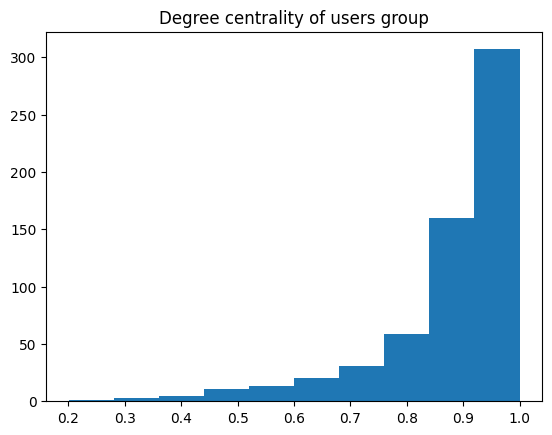

In [ ]:
# Degree centrality distribution of the G_weighted_users graph
plt.figure()
users_degree_centrality = nx.degree_centrality(G_weighted_users)
plt.hist(users_degree_centrality.values())
# plt.yscale('log')
plt.title('Degree centrality of users group')
plt.show()

In [ ]:
# Find the number of users with a degree centrality of over 0.85

sorted_users = dict(sorted(users_degree_centrality.items(), key = lambda x: x[1], reverse = True))
u_count = 0
for d in sorted_users.values():
  if d > 0.85:
    u_count += 1

print(u_count)

454


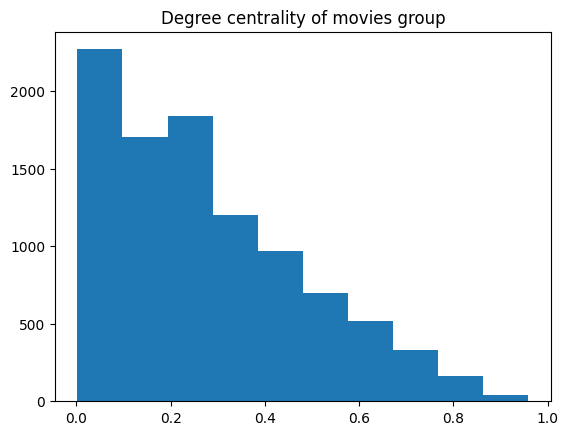

In [ ]:
# Degree centrality distribution of the G_weighted_movies graph
plt.figure()
movies_degree_centrality = nx.degree_centrality(G_weighted_movies)
plt.hist(movies_degree_centrality.values())
plt.title('Degree centrality of movies group')
plt.show()

In [ ]:
sorted_movies = dict(sorted(movies_degree_centrality.items(), key = lambda x: x[1], reverse = True))
m_count = 0
for d in sorted_movies.values():
  if d > 0.85:
    m_count += 1

print(m_count)

47


## Visualizing Networks

### Users

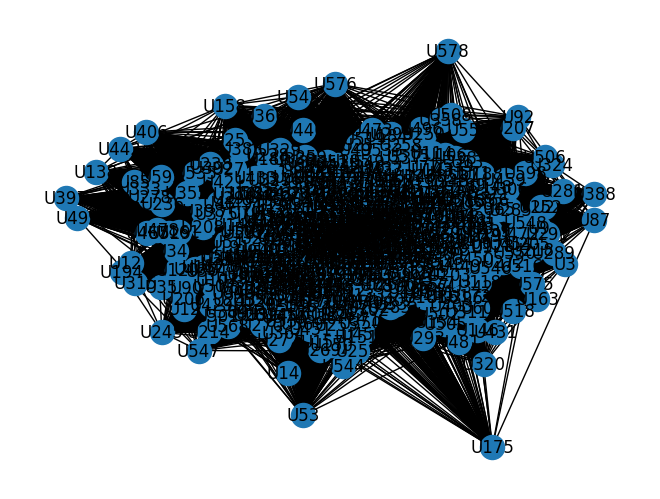

In [ ]:
# Plot the users network
pos = nx.spring_layout(G_weighted_users, seed=648)  # Seed layout for reproducible node positions
nx.draw(G_weighted_users, pos, with_labels=True)
plt.show()

#### Trimming the Network: Island Method

In [ ]:
# Island method for reducing users
# Code from the textbook
def trim_edges(g, weight=1):
  g2=nx.Graph()
  for f, to, edata in g.edges(data=True):
    if edata['weight'] > weight:
      g2.add_edge(f,to, weight=edata['weight'])
  return g2

def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]

    mn=int(min(weights))
    mx=int(max(weights))
    #compute the size of the step, so we get a reasonable step in iterations
    step=int((mx-mn)/iterations)

    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

cc = list(G_weighted_users.subgraph(c) for c in nx.connected_components(G_weighted_users))[0]
islands=island_method(cc)
print("Island Method for Users:")
for i in islands:
    # print the threshold level, size of the graph, and number of connected components
    # print (i[0], len(i[1]), len(nx.connected_component_subgraphs(i[1])))
    connected_components = list(i[1].subgraph(c) for c in nx.connected_components(i[1]))
    print (f"threshold level: {i[0]}, size of the graph: {len(i[1])}, number of connected components {len(connected_components)}")

Island Method for Users:
threshold level: 1, size of the graph: 610, number of connected components 1
threshold level: 268, size of the graph: 73, number of connected components 1
threshold level: 535, size of the graph: 21, number of connected components 1
threshold level: 802, size of the graph: 6, number of connected components 1
threshold level: 1069, size of the graph: 3, number of connected components 1
threshold level: 1336, size of the graph: 2, number of connected components 1


<Figure size 1000x600 with 0 Axes>

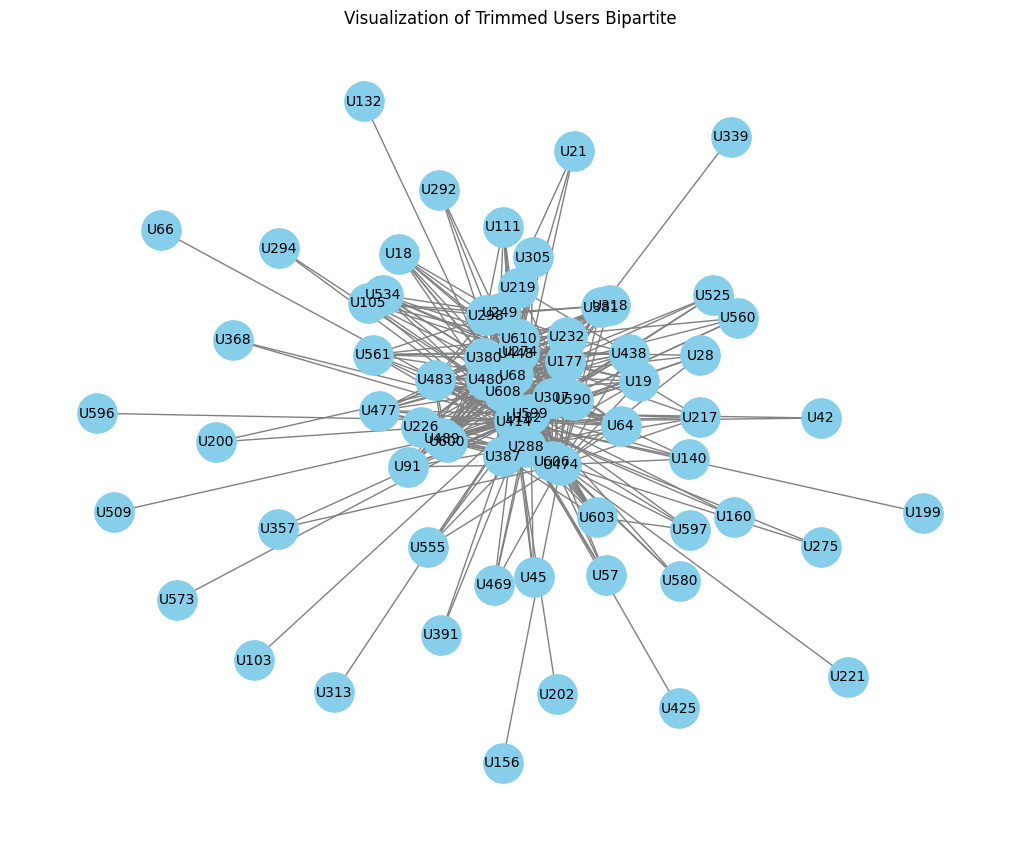

In [ ]:
# Plot trimmed users

# Choose weight 268
users_trimmed = trim_edges(G_weighted_users, 268)


plt.figure(1,figsize=(10,6))
pos = nx.spring_layout(users_trimmed, seed=748)  # Seed layout for reproducible node positions
plt.figure(figsize=(10, 8))
nx.draw(
    users_trimmed,
    pos,
    with_labels=True,
    node_color='skyblue',
    edge_color='gray',
    node_size=800,
    font_size=10
)
plt.title("Visualization of Trimmed Users Bipartite")
plt.show()

In [ ]:
# Users centrality metrics of trimmed graph

users_centrality_trimmed = pd.DataFrame({
     "Degree": nx.degree_centrality(users_trimmed),
     "Weighted Degree": dict(users_trimmed.degree(weight='weight')),
     "Betweenness": nx.betweenness_centrality(users_trimmed, weight='weight'),
     "Closeness": nx.closeness_centrality(users_trimmed),
     "Eigenvector": nx.eigenvector_centrality(users_trimmed)
 })

users_centrality_trimmed.sort_values(by='Weighted Degree', ascending=False).head(10)

,Degree,Weighted Degree,Betweenness,Closeness,Eigenvector
U414,0.972222,32816,0.323944,0.972973,0.267370
U599,0.736111,24252,0.128130,0.791209,0.254885
U68,0.625000,18952,0.064554,0.727273,0.244910
U474,0.597222,17330,0.133998,0.712871,0.225093
U274,0.527778,16221,0.018779,0.679245,0.233413
U448,0.541667,15723,0.035798,0.685714,0.233300
U380,0.430556,12406,0.010172,0.637168,0.209899
U480,0.402778,10962,0.003717,0.626087,0.206092
U288,0.402778,10700,0.040102,0.626087,0.190628
U608,0.388889,10466,0.010563,0.620690,0.200230


### Movies

In [ ]:
# Plot the movies network

#pos = nx.spring_layout(G_weighted_movies, seed=648)  # Seed layout for reproducible node positions
#nx.draw(G_weighted_movies, pos, with_labels=True)
#plt.show()

#### Trimming the Network: Island Method

In [ ]:
# Island method for reducing movies
cc_movies = list(G_weighted_movies.subgraph(c) for c in nx.connected_components(G_weighted_movies))[0]
islands_movies=island_method(cc_movies)
print("Island Method for Movies:")
for i in islands_movies:
    # print the threshold level, size of the graph, and number of connected components
    # print (i[0], len(i[1]), len(nx.connected_component_subgraphs(i[1])))
    connected_components = list(i[1].subgraph(c) for c in nx.connected_components(i[1]))
    print (f"threshold level: {i[0]}, size of the graph: {len(i[1])}, number of connected components {len(connected_components)}")

Island Method for Movies:
threshold level: 1, size of the graph: 6275, number of connected components 1
threshold level: 47, size of the graph: 369, number of connected components 1
threshold level: 93, size of the graph: 101, number of connected components 1
threshold level: 139, size of the graph: 32, number of connected components 1
threshold level: 185, size of the graph: 8, number of connected components 2


<Figure size 1000x600 with 0 Axes>

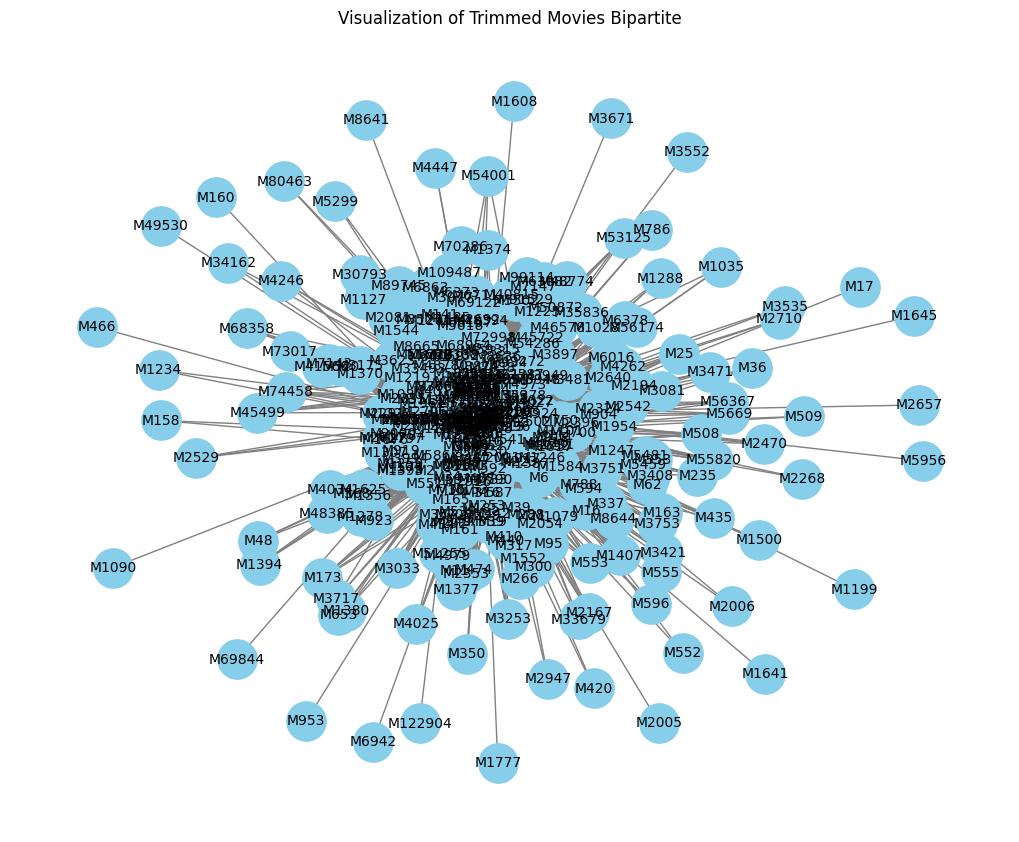

In [ ]:
# Plot trimmed movies

# Choose weight 47
movies_trimmed = trim_edges(G_weighted_movies, 47)

plt.figure(1,figsize=(10,6))
pos = nx.spring_layout(movies_trimmed, seed=748)  # Seed layout for reproducible node positions
plt.figure(figsize=(10, 8))
nx.draw(
    movies_trimmed,
    pos,
    with_labels=True,
    node_color='skyblue',
    edge_color='gray',
    node_size=800,
    font_size=10
)
plt.title("Visualization of Trimmed Movies Bipartite")
plt.show()

In [ ]:
# This code chunk takes a long time
# Movies centrality metrics
movies_centrality_trimmed = pd.DataFrame({
     "Degree": dict(movies_trimmed.degree()),
     "Weighted Degree": dict(movies_trimmed.degree(weight='weight')),
     "Closeness": nx.closeness_centrality(movies_trimmed),
     "Eigenvector": nx.eigenvector_centrality(movies_trimmed)
 })

movies_centrality_trimmed.sort_values(by='Weighted Degree', ascending=False).head(10)

,Degree,Weighted Degree,Closeness,Eigenvector
M356,335,27070,0.917706,0.120015
M2571,292,23074,0.828829,0.115814
M296,282,22735,0.810573,0.117283
M318,270,21257,0.789700,0.115865
M260,271,20605,0.791398,0.115118
M593,251,19249,0.758763,0.115125
M480,237,18241,0.737475,0.112310
M1196,242,17906,0.744939,0.112307
M2959,227,16919,0.722986,0.108557
M589,221,16477,0.714563,0.110695


## Finding Communities

A communtiy in a network is detected by maximizing the modularity of a network. These are groups of nodes within a network that are more densely connected to each other than to nodes outside the group.

### User Communities

Community 1: ['U103', 'U132', 'U140', 'U160', 'U199', 'U202', 'U275', 'U28', 'U294', 'U313', 'U339', 'U357', 'U368', 'U391', 'U414', 'U42', 'U425', 'U45', 'U469', 'U509', 'U525', 'U555', 'U57', 'U573', 'U580', 'U596', 'U599', 'U66']
Community 2: ['U156', 'U177', 'U182', 'U221', 'U226', 'U232', 'U274', 'U288', 'U307', 'U380', 'U381', 'U387', 'U474', 'U477', 'U480', 'U483', 'U489', 'U590', 'U597', 'U600', 'U603', 'U606', 'U608', 'U64', 'U91']
Community 3: ['U105', 'U111', 'U18', 'U19', 'U200', 'U21', 'U217', 'U249', 'U292', 'U298', 'U305', 'U318', 'U448', 'U534', 'U560', 'U561', 'U610', 'U68']
Community 4: ['U219', 'U438']


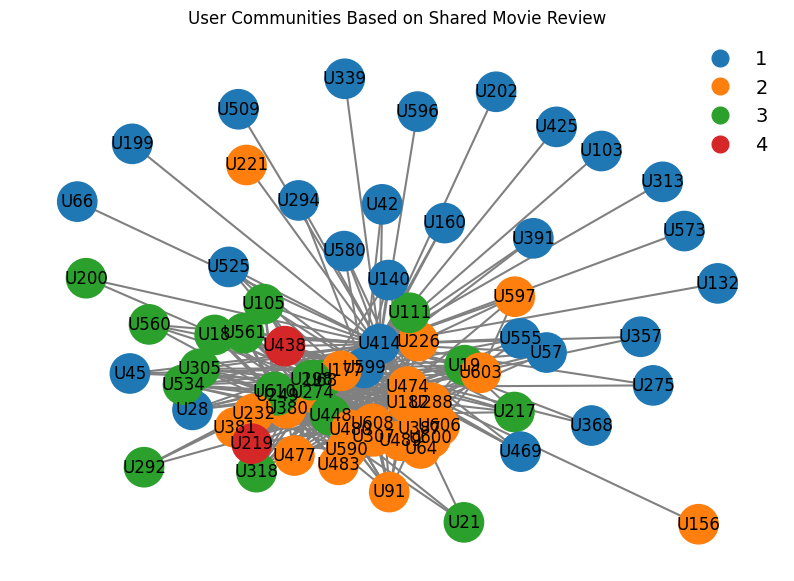

In [ ]:
#  Detect user communities
#  Use the trimmed subgraph - users_trimmed

from networkx.algorithms.community import greedy_modularity_communities

user_communities = list(greedy_modularity_communities(users_trimmed))

# Print each community
for i, group in enumerate(user_communities):
  print(f"Community {i+1}: {sorted(group)}")

# Assign colors to each community
user_community_colors = {}
community_colors = {}
color_palette = plt.cm.tab10.colors  # Up to 10 distinct colors

for i, comm in enumerate(user_communities):
  community_colors[i+1] = color_palette[i]
  for user in comm:
    user_community_colors[user] = color_palette[i]

# Draw the graph
pos = nx.spring_layout(users_trimmed, seed=42)
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(users_trimmed, pos,
                        node_color=[user_community_colors[n] for n in users_trimmed.nodes()],
                        node_size=800)
nx.draw_networkx_edges(users_trimmed, pos, width=1.5, edge_color='gray')
nx.draw_networkx_labels(users_trimmed, pos)
plt.title("User Communities Based on Shared Movie Review")
plt.axis('off')

import matplotlib.lines as mlines

legend_elements = []
for key, value in community_colors.items():
    legend_elements.append(mlines.Line2D([], [], color=value, marker='o',
                                         linestyle='None', label=key))

# Create legend
plt.legend(handles=legend_elements,
           loc='upper right',
           markerscale = 2,
           fontsize  = 14,
           frameon = False)

plt.show()


#### Centrality within communities

In [ ]:
# Assign a label to each node
user_communities_dict = {}

for i, u_comm in enumerate(user_communities):
  for node in u_comm:
    user_communities_dict[node] = f'Community {i+1}'

In [ ]:
# Create a copy of the users_centrality_trimmed
users_centrality_trimmed_copy =  users_centrality_trimmed.copy()

# Reset index and include userId column
users_centrality_trimmed_copy["userId"] = users_centrality_trimmed_copy.index

users_centrality_trimmed_copy.reset_index(inplace = True, drop = True)


# Apply the mapping to the 'userId' column
users_centrality_trimmed_copy["Community"] =  users_centrality_trimmed_copy["userId"].map(user_communities_dict)

users_centrality_trimmed_copy.head()

,Degree,Weighted Degree,Betweenness,Closeness,Eigenvector,userId,Community
0,0.111111,2460,0.000391,0.521739,0.076378,U18,Community 3
1,0.736111,24252,0.128130,0.791209,0.254885,U599,Community 1
2,0.430556,12406,0.010172,0.637168,0.209899,U380,Community 2
3,0.972222,32816,0.323944,0.972973,0.267370,U414,Community 1
4,0.527778,16221,0.018779,0.679245,0.233413,U274,Community 2


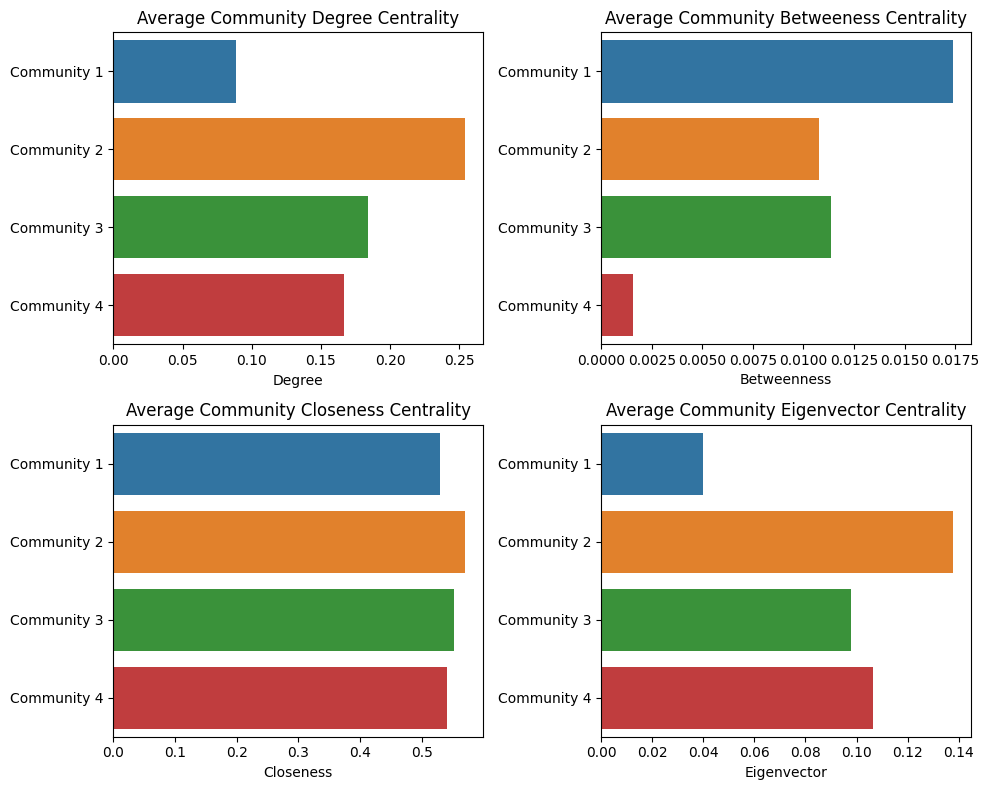

In [ ]:
# Find average centrality measures within the communities

aver_community_centrality = users_centrality_trimmed_copy.groupby("Community", as_index = False).agg({'Degree': 'mean',
                                                         'Weighted Degree': 'mean',
                                                         'Betweenness' : 'mean',
                                                         'Closeness' :'mean',
                                                         'Eigenvector' : 'mean'
                                                         })

aver_community_centrality

# Visualize average centrality measures
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10,8))

sns.barplot(data = aver_community_centrality, x = "Degree", y = "Community",
            hue = "Community", ax = ax[0][0])
ax[0][0].set_title("Average Community Degree Centrality")
ax[0][0].set_ylabel("")

sns.barplot(data = aver_community_centrality, x = "Betweenness", y = "Community",
            hue = "Community", ax = ax[0][1])
ax[0][1].set_title("Average Community Betweeness Centrality")
ax[0][1].set_ylabel("")

sns.barplot(data = aver_community_centrality, x = "Closeness", y = "Community",
            hue = "Community",ax = ax[1][0])
ax[1][0].set_title("Average Community Closeness Centrality")
ax[1][0].set_ylabel("")

sns.barplot(data = aver_community_centrality, x = "Eigenvector", y = "Community",
            hue = "Community", ax = ax[1][1])
ax[1][1].set_title("Average Community Eigenvector Centrality")
ax[1][1].set_ylabel("")

plt.tight_layout()
plt.show()

#### Counts by genre and average rating within communities

In [ ]:
# Find the number of movies rated by genres and average genre ratings by community
for i, u_comm in enumerate(user_communities):
  gbo = movies_df[movies_df["userId"].isin(u_comm)].groupby("genres")
  print(f'User community {i+1}:')
  #print(gbo.agg({"genres":"count", "rating":"mean"}).sort_index())
  print(gbo.agg(genre_counts = ("genres", "count"),
                avg_Rating = ("rating", "mean")).sort_values("genre_counts",
                                                             ascending = False).head(3))
  print("\n")
  #print(f'User community {i+1}:')
  #print(df)

User community 1:
        genre_counts  avg_Rating
genres                          
Action          4818    3.239415
Comedy          4131    3.269305
Drama           2933    3.534606


User community 2:
        genre_counts  avg_Rating
genres                          
Comedy          5707    3.260820
Action          5245    3.296663
Drama           4012    3.612039


User community 3:
        genre_counts  avg_Rating
genres                          
Action          4942    3.357345
Comedy          3628    3.174338
Drama           1637    3.456017


User community 4:
        genre_counts  avg_Rating
genres                          
Action           536    3.262127
Comedy           270    3.159259
Drama            122    3.250000




### Movie Communities

Community 1: ['M1036', 'M1080', 'M1089', 'M109487', 'M111', 'M1136', 'M1193', 'M1197', 'M1198', 'M1206', 'M1208', 'M1213', 'M1221', 'M1222', 'M122904', 'M1246', 'M1258', 'M1527', 'M1682', 'M1704', 'M1721', 'M1732', 'M1961', 'M2028', 'M2324', 'M2329', 'M2355', 'M2502', 'M2628', 'M2706', 'M2716', 'M2762', 'M2858', 'M2918', 'M293', 'M2959', 'M2997', 'M3052', 'M30793', 'M3114', 'M3147', 'M32587', 'M33493', 'M33794', 'M3481', 'M3578', 'M35836', 'M3793', 'M3948', 'M3949', 'M3977', 'M3996', 'M4011', 'M4022', 'M4027', 'M40815', 'M41566', 'M4226', 'M4306', 'M44191', 'M45499', 'M45722', 'M46578', 'M48394', 'M48516', 'M48774', 'M4878', 'M48780', 'M4886', 'M4896', 'M49272', 'M4963', 'M4973', 'M4993', 'M4995', 'M50872', 'M51662', 'M5218', 'M527', 'M53125', 'M5349', 'M5378', 'M54001', 'M541', 'M5418', 'M54286', 'M5445', 'M5459', 'M5481', 'M5502', 'M56174', 'M5618', 'M5816', 'M58559', 'M59315', 'M5952', 'M5989', 'M60069', 'M6016', 'M63082', 'M6333', 'M6365', 'M6373', 'M6377', 'M6539', 'M6711', 'M6815

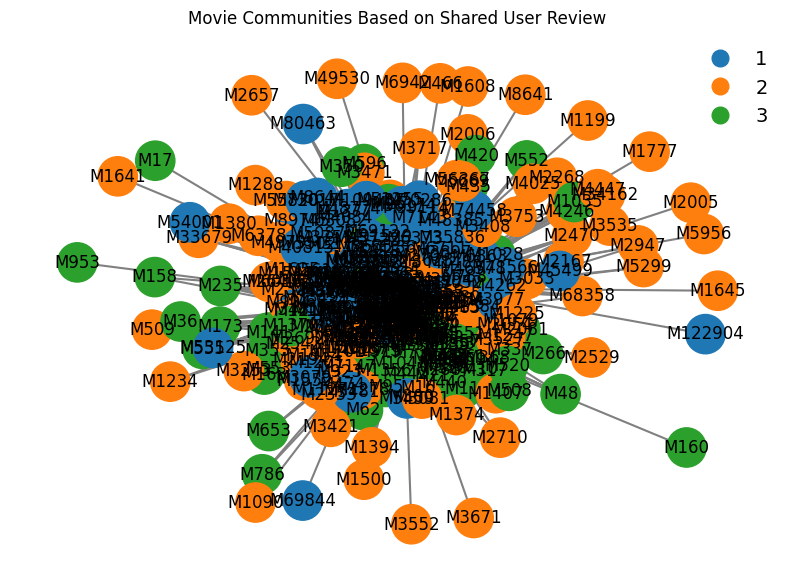

In [ ]:
# TO DO: Detect movies communities

from networkx.algorithms.community import greedy_modularity_communities

movie_communities = list(greedy_modularity_communities(movies_trimmed))

# # Print each community
for i, group in enumerate(movie_communities):
  print(f"Community {i+1}: {sorted(group)}")

# Assign colors to each community
movie_community_colors = {}
movie_comm_colors = {}
color_palette = plt.cm.tab10.colors  # Up to 10 distinct colors

for i, comm in enumerate(movie_communities):
  movie_comm_colors[i+1] = color_palette[i]
  for movie in comm:
    movie_community_colors[movie] = color_palette[i]

# Draw the graph
pos = nx.spring_layout(movies_trimmed, seed=42)
plt.figure(figsize=(10, 7))
nx.draw_networkx_nodes(movies_trimmed, pos,
                        node_color=[movie_community_colors[n] for n in movies_trimmed.nodes()],
                        node_size=800)
nx.draw_networkx_edges(movies_trimmed, pos, width=1.5, edge_color='gray')
nx.draw_networkx_labels(movies_trimmed, pos)
plt.title("Movie Communities Based on Shared User Review")
plt.axis('off')

import matplotlib.lines as mlines

legend_elements = []
for key, value in movie_comm_colors.items():
    legend_elements.append(mlines.Line2D([], [], color=value, marker='o',
                                         linestyle='None', label=key))

# Create legend
plt.legend(handles=legend_elements,
           loc='upper right',
           markerscale = 2,
           fontsize  = 14,
           frameon = False)


plt.show()

## Make Recommendations

### Movies connected by two users

In [ ]:
def find_shared_nodes_within_group(G, node1, node2):
    '''
    Returns a list of shared neighbors between node1 and node2 (node1 and node2 must be part of the same group)
    '''
    # Nodes must be part of the same group
    assert G.nodes[node1]['bipartite'] == G.nodes[node2]['bipartite'], "Nodes must be under the same group"

    # Grab neighbors of node 1
    node1_neighbors = G.neighbors(node1)
    # Grab neighbors of node 2
    node2_neighbors = G.neighbors(node2)

    # Find intersection
    shared_nodes = set(node1_neighbors).intersection(node2_neighbors)
    return shared_nodes

In [ ]:
# Find the shared movies between user 1 and user 2

find_shared_nodes_within_group(G, "U1", "U2")

{'M333', 'M3578'}

### Find new movies for a user

In [ ]:
def compare_ratings(user1, user2, df = movies_df):

  """ Compared users by finding the intersection of movie titles that were
  rated by boht users. Function to be used in new_movie_recs"""

  #u1 = df[df["userId"] == user1]
  #u2 = df[df["userId"] == user2]

  #shared_list = list(set(u1["title"]).intersection(set(u2["title"])))
  #print(shared_list)

  # Use function find_shared_nodes_within_group to find the similar movies
  # between users
  shared_list = find_shared_nodes_within_group(G, user1, user2)

  shared_df = df[(df["userId"].isin([user1, user2])) &
          (df["movieId"].isin(shared_list))].sort_values(by = "title")

  shared_pivot = pd.pivot_table(data = shared_df,
                 values="rating",
                 index="title",
                 columns="userId")

  #shared_pivot = shared_pivot.reset_index()

  #shared_pivot.index.name = None

  return shared_pivot


#compare_ratings("U594", "U595", movies_df)

def new_movie_recs(input_user, df = movies_df, weighted_network = G_weighted_users):

  """ Recommendation function that takes in a specified user from a data frame
  containing information about userId, movieId, rating, title, genre.

  Finds top 10 connected users from the projected weight graph, loops through each
  connected user, extracting the genres and movies that had a high shared rating
  (>= 3.5).

  Looks for all the movies with a rating of 3.5 or higher in the
  genre where a connected movie was highly rated and extracts all the movies from
  connected nodes that the input user has not rated.

  A data frame is returned with recommended movies based on genre from all connected
  users.

  input_user: input user
  df: movie dataframe Default: movies_df
  weighted_network: A networkx projected weighted graph of the users in df
  """
  input_user_movie_list = list(df[df["userId"] == input_user]["title"])

  # iniate a movie recs dictionary
  movie_recs = {}


  #sorted_dictionary of connected nodes
  sorted_dict = dict(sorted(dict(weighted_network[input_user]).items(),
                            key=lambda item: item[1]['weight'], reverse = True))

  #Loop through top 10 connected nodes in weighted graph
  for shared_user in list(sorted_dict.keys())[0:10]:
    #print(shared_user)

    # Find shared moveis between the input user and the shared_user
    ## Returns a pivot table with linked reviews
    shared_ratings = compare_ratings(input_user, shared_user, movies_df)

    # find the movie titles between the users that had a rating above threshold
    movie_list = []
    for i, row in shared_ratings.iterrows():
      if (row.loc[input_user] >= 3.5) & (row.loc[shared_user] >= 3.5):
        movie_title = i
        # Update the shared movie list
        movie_list.append(movie_title)


    # Using above shared movie list find all genres
    movies_genres = set(movies_df[movies_df["title"].isin(movie_list)]["genres"])
    #print(movies_genres)

    # For the shared_user pull all the movies in that genres
    # if they have a rating of 3.5 or higher

    shared_user_movies = movies_df[(movies_df["userId"] == shared_user) &
    (movies_df["genres"].isin(movies_genres)) &
     (~movies_df["title"].isin(input_user_movie_list)) &
      (movies_df["rating"] >= 3.5)][["title", "genres"]]

    # Loop through the unique movies that don't share a rating with input user
    ## Update the movie_recs dictionary


    for i, row in shared_user_movies.iterrows():
      if row['genres'] in movie_recs.keys():
        if row['title'] in movie_recs.values():
          continue
        else:
          movie_recs[row['genres']].append(row["title"])
      else:
        movie_recs[row['genres']] = [row['title']]

  # Create dataframe based on the movie_recs dictionary

  recommendations_df = pd.DataFrame({"Genres" : movie_recs.keys(), "Title" : movie_recs.values()})
  recommendations_df = recommendations_df.explode("Title")
  recommendations_df.reset_index(inplace = True, drop = True)

  #Return the data frame
  return recommendations_df

In [ ]:
new_movie_recs("U2")

,Genres,Title
0,Action,Heat (1995)
1,Action,GoldenEye (1995)
2,Action,From Dusk Till Dawn (1996)
3,Action,Braveheart (1995)
4,Action,Rumble in the Bronx (Hont faan kui) (1995)
...,...,...
4409,Documentary,Dear Zachary: A Letter to a Son About His Fath...
4410,Documentary,"Food, Inc. (2008)"
4411,Documentary,"Art of the Steal, The (2009)"
4412,Documentary,Jiro Dreams of Sushi (2011)


In [ ]:
# Validate that the movies recommended were not in the list movies that
# the input user also reviewed

## set(movies_df[movies_df["userId"] == "U2"]["title"]).intersection(set(new_movie_recs("U2")["Title"]))

In [ ]:
def find_user_similarity_score(G, node1, node2):
    '''
    Returns the similarity score between node1 (user1) and node2 (user2) by
    finding the fraction of shared movies
    '''
    # Nodes must be part of the same group
    assert G.nodes[node1]['bipartite'] == G.nodes[node2]['bipartite'], "Nodes must be under the same group"

    # Grab the shared nodes
    shared_nodes = find_shared_nodes_within_group(G, node1, node2)

    # Find percentage of movie nodes that are shared
    return len(shared_nodes) / len(movies)

# Find the similarity score between users 'U39' and 'U49'
similarity_score = find_user_similarity_score(G, 'U39', 'U49')

print(similarity_score)

0.00041135335252982314


In [ ]:
def find_most_similar_users(G, user):
    '''
    Returns the most similar users for a given user
    '''
    # Must be user node
    assert G.nodes[user]['bipartite'] == "user", "Node must be part of the user group"

    # Remove the user
    users2=users.copy()
    users2.remove(user)

    similarities = defaultdict(list)
    for u in users2:
        similarity_score = find_user_similarity_score(G, user, u)
        similarities[similarity_score].append(u)

    # Find the maximum similarity
    max_similarity = max(similarities.keys())

    # Return list of users that share maximal similarity
    return similarities[max_similarity][:5]

# Find the most similar users to U288
print(find_most_similar_users(G, 'U288'))

['U414']


In [ ]:
# Find highly rated movies from the most similar user to use for recommendations for U288
popular_movies_from_most_similar_user = dict(sorted(dict(G['U414']).items(), key=lambda item: item[1]['weight'], reverse = True))
movies_from_original_user = dict(sorted(dict(G['U288']).items(), key=lambda item: item[1]['weight'], reverse = True))
unique_movie_list = list(set(popular_movies_from_most_similar_user.keys()) - set(movies_from_original_user.keys())) # remove already seen movies
top_movies_from_most_similar_user = [int(s.replace('M', '')) for s in unique_movie_list[:10]]
movies_data[movies_data['movieId'].isin(top_movies_from_most_similar_user)]

,movieId,title,genres
1109,1442,Prefontaine (1997),Drama
1247,1658,"Life Less Ordinary, A (1997)",Romance|Thriller
1548,2084,Newsies (1992),Children|Musical
1603,2145,Pretty in Pink (1986),Comedy|Drama|Romance
1673,2252,Hero (1992),Comedy|Drama
3733,5178,Fun (1994),Crime|Drama
5728,27899,What the #$*! Do We Know!? (a.k.a. What the Bl...,Comedy|Documentary|Drama
6369,49910,Freedom Writers (2007),Drama
6454,52283,"Reaping, The (2007)",Horror|Thriller
6481,52973,Knocked Up (2007),Comedy|Drama|Romance


## Summary:

- The data set contained 610 user nodes, 9724 movies nodes and 100836 edges (ratings) in this data set.
- Two bipartite graphs were created where Nodes = users and movies, Edges = ratings and Edge weight = rating value.

  - A user network
    - The distribution of the degree centrality was left skewed indicating that the majority of users were connected to many other users. Over 300 users have a centrality close to 1.0, indicating these users have broad overlap in their movie preferences with many others.
    - 454/610 users had degree centrality measure greater than 0.85.

  - A movies network.
    - As opposed to the user network, the distribution of degrees centrality with in movie network was right skewed
      - Only a 47/9,724 movies had a degree centrality measure greater than 0.85.
      - Only a small number of movies are highly central, likely due to being widely rated (i.e., popular or mainstream titles).


- Networks were trimmed using the island method.
  - 73 nodes made up the trimmed user network
    - Within the trimmed network U414 had the highest degree centrality. Indicating this user has rated a lot of movies and may be important in getting other users to rate movies.
    - Hence the most influential and central user in the network.
    - Other top users, such as U599 and U68, are also highly connected and influential, though their positions within the network are slightly more localized. These users likely represent highly active raters with broadly overlapping movie preferences, making them ideal anchors for collaborative filtering or influence propagation studies.

  - 369 nodes made up the trimmed movie network
  
   - M356 is the most connected movie — rated alongside other movies by a large number of users.It acts as a hub movie, likely a popular or mainstream title that many people rated.Their high eigenvector scores also suggest they are connected to other influential titles, reinforcing their central role in shaping viewing patterns.

- Communities were detected within the trimmed networks with a focus on the user communities
  - Community 2 had the highest average degree centrality
    - Interestingly, U414 that was identified as having the highest degree centrality was not in this community but in Community 1.
  - Community 1 had the highest average betweenness centrality
    - Taking U414 as an example, this user might have more influence in recommnending new movies as they are often found on the shortest path between users.
  - Closeness centrality was fairly similar throughout each community.
  - Community 4 only consisted of 2 nodes
  - Top genres were ratings were made are similar among all communities with the exception of Community 2, that rated more comedy movies.
  - Average Ratings between genres within and between genres differed slightly.

- Using a network analysis to identify connected similar users and comparing the ratings of movies in different genres can be helpful to make recommendations.